In [15]:
%matplotlib inline
import tensorflow as tf
from tensorflow.contrib.learn.python.learn.datasets.mnist import read_data_sets
tf.set_random_seed(0)

In [2]:
mnist = read_data_sets("data", one_hot=True, reshape=False, validation_size=0)

Extracting data/train-images-idx3-ubyte.gz
Extracting data/train-labels-idx1-ubyte.gz
Extracting data/t10k-images-idx3-ubyte.gz
Extracting data/t10k-labels-idx1-ubyte.gz


In [3]:
X = tf.placeholder(tf.float32, [None, 28, 28, 1])

In [4]:
Y_ = tf.placeholder(tf.float32, [None, 10])

# Standard nerural net setup

In [5]:
# W1 = tf.Variable(tf.truncated_normal([28*28, 500], stddev=0.1))
# B1 = tf.Variable(tf.ones([500])/10)

# W2 = tf.Variable(tf.truncated_normal([500, 500], stddev=0.1))
# B2 = tf.Variable(tf.ones([500])/10)

# W3 = tf.Variable(tf.truncated_normal([500, 500], stddev=0.1))
# B3 = tf.Variable(tf.ones([500])/10)

# W4 = tf.Variable(tf.truncated_normal([500, 500], stddev=0.1))
# B4 = tf.Variable(tf.ones([500])/10)

# W5 = tf.Variable(tf.truncated_normal([500, 10], stddev=0.1))
# B5 = tf.Variable(tf.ones([10])/10)

In [6]:
# XX = tf.reshape(X, [-1, 784])

In [7]:
# Y1 = tf.nn.relu(tf.matmul(XX, W1) + B1)
# Y2 = tf.nn.relu(tf.matmul(Y1, W2) + B2)
# Y3 = tf.nn.relu(tf.matmul(Y2, W3) + B3)
# Y4 = tf.nn.relu(tf.matmul(Y3, W4) + B4)
# Ylogits = tf.matmul(Y4, W5) + B5
# Y  = tf.nn.softmax(Ylogits)

# CNN setup

In [19]:
W1 = tf.Variable(tf.truncated_normal([5, 5, 1, 4], stddev=0.1))
B1 = tf.Variable(tf.ones([4])/10)

W2 = tf.Variable(tf.truncated_normal([4, 4, 4, 8], stddev=0.1))
B2 = tf.Variable(tf.ones([8])/10)

W3 = tf.Variable(tf.truncated_normal([4, 4, 8, 12], stddev=0.1))
B3 = tf.Variable(tf.ones([12])/10)

W4 = tf.Variable(tf.truncated_normal([7*7*12, 200], stddev=0.1))
B4 = tf.Variable(tf.ones([200])/10)

W5 = tf.Variable(tf.truncated_normal([200, 10], stddev=0.1))
B5 = tf.Variable(tf.ones([10])/10)

In [20]:
stride = 1  # output is still 28x28
Ycnv1 = tf.nn.conv2d(X, W1, strides=[1, stride, stride, 1], padding='SAME')
Y1 = tf.nn.relu(Ycnv1 + B1)

stride2 = 2  # output is now 14x14
Ycnv2 = tf.nn.conv2d(Y1, W2, strides=[1, stride2, stride2, 1], padding='SAME')
Y2 = tf.nn.relu(Ycnv2 + B2)

stride3 = 2  # output is now 14x14
Ycnv3 = tf.nn.conv2d(Y2, W3, strides=[1, stride3, stride3, 1], padding='SAME')
Y3 = tf.nn.relu(Ycnv3 + B3)

XXX = tf.reshape(Y3, [-1, 588])

Y4 = tf.nn.relu(tf.matmul(XXX, W4) + B4)
Ylogits = tf.matmul(Y4, W5) + B5
Y  = tf.nn.softmax(Ylogits)

# Cost and training

In [21]:
# cross_entropy = -tf.reduce_mean(Y_ * tf.log(Y)) * 1000.0 
cross_entropy = tf.nn.softmax_cross_entropy_with_logits( logits=Ylogits,labels= Y_)
cross_entropy = tf.reduce_mean(cross_entropy)*100

In [22]:
correct_prediction = tf.equal(tf.argmax(Y, 1), tf.argmax(Y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [23]:
train_step = tf.train.AdamOptimizer(0.005).minimize(cross_entropy)

In [24]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [25]:
def training_step(i, update_test_data, update_train_data):

    # training on batches of 100 images with 100 labels
    batch_X, batch_Y = mnist.train.next_batch(100)

    if update_train_data:
        a, c = sess.run([accuracy, cross_entropy], feed_dict={X: batch_X, Y_: batch_Y})
        print(str(i) + ": accuracy:" + str(a) + " loss: " + str(c))
        train_score_log.append((i,a))
    if update_test_data:
        a, c = sess.run([accuracy, cross_entropy], feed_dict={X: mnist.test.images, Y_: mnist.test.labels})
        print(str(i) + ": ********* epoch " + str(i*100//mnist.train.images.shape[0]+1) + " ********* test accuracy:" + str(a) + " test loss: " + str(c))
        test_score_log.append( (i,a) )
        
    # the backpropagation training step
    sess.run(train_step, feed_dict={X: batch_X, Y_: batch_Y})

In [26]:
train_score_log = []
test_score_log = []
for i in range(4000+1): training_step(i, i % 50 == 0, i % 10 == 0)

0: accuracy:0.15 loss: 236.028
0: ********* epoch 1 ********* test accuracy:0.1067 test loss: 237.426
10: accuracy:0.46 loss: 195.473
20: accuracy:0.79 loss: 77.6947
30: accuracy:0.83 loss: 52.5217
40: accuracy:0.91 loss: 35.709
50: accuracy:0.86 loss: 45.2003
50: ********* epoch 1 ********* test accuracy:0.8966 test loss: 34.6794
60: accuracy:0.9 loss: 35.7489
70: accuracy:0.91 loss: 31.0885
80: accuracy:0.92 loss: 26.0577
90: accuracy:0.93 loss: 23.3946
100: accuracy:0.96 loss: 14.0265
100: ********* epoch 1 ********* test accuracy:0.9333 test loss: 23.9177
110: accuracy:0.92 loss: 21.2289
120: accuracy:0.9 loss: 21.5063
130: accuracy:0.95 loss: 11.3998
140: accuracy:0.94 loss: 14.9317
150: accuracy:0.93 loss: 15.102
150: ********* epoch 1 ********* test accuracy:0.9505 test loss: 16.1505
160: accuracy:0.98 loss: 14.1545
170: accuracy:0.98 loss: 10.5602
180: accuracy:0.97 loss: 9.15032
190: accuracy:0.94 loss: 26.1005
200: accuracy:0.98 loss: 9.39048
200: ********* epoch 1 ********* 

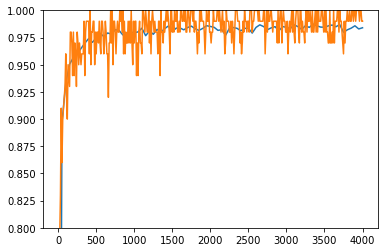

In [27]:
import matplotlib.pyplot as plt

plt.plot(list(zip(*test_score_log))[0],list(zip(*test_score_log))[1])
plt.plot(list(zip(*train_score_log))[0],list(zip(*train_score_log))[1])
plt.ylim(0.8,1)
plt.show()

In [28]:
sorted(list(zip(*test_score_log))[1])[-1]

0.9874